## This notebook is for decoder based analysis of the game data for preparing the pilot experiment

In [1]:
# import libraries
import sys
sys.path.insert(0,'/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/PilotExperiment/BrainMachineInterfaces_pilotExperiment')
from DataAnalysis.dataAnalysisClasses import *
import matplotlib.pyplot as plt

In [2]:
# Retrieve training and test data

dataProcessor = ProcessData('../GameSaves/Ashwin_09_01__17_05_10mins_updated.pkl','../GameSaves/Ashwin_09_01__17_20_90s_updated.pkl')
dataProcessor.retrieveTrainingFeatureData(rigidBodyGroup= "B")
dataProcessor.retrieveTestFeatureData(rigidBodyGroup="B")
print("Program successfully executed")

pygame 2.5.2 (SDL 2.28.3, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html
Program successfully executed


In [3]:
# Normalise training and test data
dataProcessor.retrieveTestOutputs()
dataProcessor.retrieveTrainingOutputs()

dataProcessor.normaliseDatasets(byVariance=False,delCalibrationData=True)
print(dataProcessor.outputTrainingData.shape,dataProcessor.featureTrainingData.shape)




(17008, 2) (17008, 6)


In [90]:
dataProcessor.featureTrainingData = np.diff(dataProcessor.featureTrainingData,axis = 0)
dataProcessor.featureTestData = np.diff(dataProcessor.featureTestData,axis = 0)
dataProcessor.outputTestData = dataProcessor.outputTestData[1:]
dataProcessor.outputTrainingData = dataProcessor.outputTrainingData[2:]
dataProcessor.performLinearRegression()
dataProcessor.gatherPredictions()
dataProcessor.exportPredictions(fileName= "../CursorPredictors/Ashwin_09_01_rigidBodyB.npz")



-0.0005049113618957879


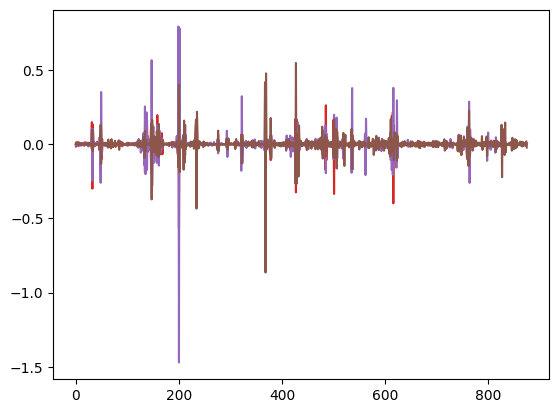

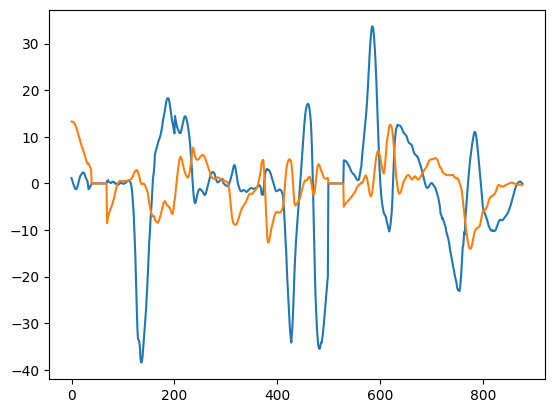

In [94]:

score = dataProcessor.reg.score(dataProcessor.featureTestData,dataProcessor.outputTestData[1:])
print(score)

plt.plot(dataProcessor.featureTestData[1000:2000,:])
plt.show()
plt.plot(dataProcessor.outputTestData[1000:2000,:])
plt.show()




[[ 0.15621996 -0.98720926  0.03183074]]
[[ 0.19726891 -0.05048038  0.97904888]]
1880
(1880, 2)


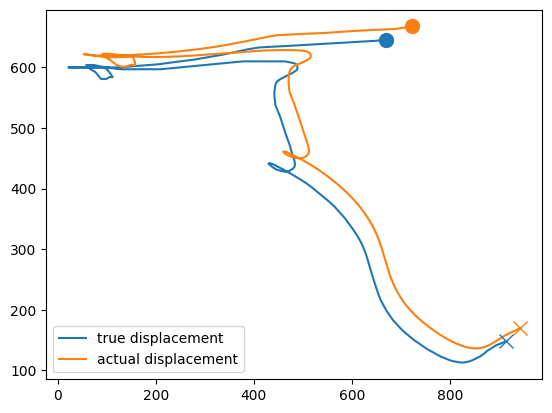

In [60]:
# THIS SECTION SHOWS THAT BY HAVING THE CONTROL RIGID BODY INFORMATION, ONE CAN
# PERFECTLY DECODE THE CURSOR VELOCITY AND POSITION

print(dataProcessor.testDataGameEngine.pcaleftRight.components_)
print(dataProcessor.testDataGameEngine.pcaUpDown.components_)
# retrieve cal matrix
calMatrix = dataProcessor.testDataGameEngine.calibrationMatrix
controlData = dataProcessor.testDataGameEngine.controlRigidBodyDatastore

# calibrated
controlData_calibrated = np.matmul(calMatrix,controlData[:,:3].transpose()).transpose()

# delete calibration data
calIdx = dataProcessor.testFinalCalibrationIdx
controlData_calibrated = controlData_calibrated[calIdx+1:]
controlData_calibrated.shape # shape 1877 x 3

# fetch list of velocities
velocityData = dataProcessor.testDataGameEngine.cursorVelocityWriteDatastore[1:]
velocityData.shape # shape 1877 x 2

# now cal velocities from control Data
calcVelocitiesX = dataProcessor.testDataGameEngine.pcaleftRight.transform(controlData_calibrated)

calcVelocitiesY = dataProcessor.testDataGameEngine.pcaUpDown.transform(controlData_calibrated)

predVelX = np.zeros(calcVelocitiesX.shape)
predVelY = np.zeros(calcVelocitiesX.shape)
print(len(calcVelocitiesX))
displacementX = 1270 // 2
displacementY = 740 // 2

cursor = dataProcessor.testDataGameEngine.cursor

dists = dataProcessor.testDataGameEngine.cursorPositionWriteDatastore[1:,:]
estDists = np.zeros(dists.shape)
for i in range(0,len(velocityData[:,0])-1):
    if cursor.xInvert:
        normalised_x_val = 1 -  (  calcVelocitiesX[i] - cursor.userMinXValue) / cursor.xRange
    else:
        normalised_x_val =   (calcVelocitiesX[i] - cursor.userMinXValue) / cursor.xRange
    if cursor.yInvert:
        normalised_y_Val = ( calcVelocitiesY[i] - cursor.userMinYValue) / cursor.yRange
    else:  
        normalised_y_Val = 1 - (calcVelocitiesY[i] - cursor.userMinYValue) / cursor.yRange


    x_target = normalised_x_val * 1270
    y_target = normalised_y_Val * 740

    useActualDist = False
    if useActualDist:
        distanceX = x_target - dists[i,0]
        distanceY = y_target - dists[i,1]
    else:
        distanceX = x_target - displacementX
        distanceY = y_target - displacementY

    predVelX[i] = distanceX * 0.06
    predVelY[i] = distanceY * 0.06

    estDists[i,0] = displacementX
    estDists[i,1] = displacementY

    displacementX = displacementX + predVelX[i] * 0.9
    displacementY = displacementY + predVelY[i] * 0.9

predVels = np.zeros(velocityData.shape)
predVels[:,0] = predVelX.reshape(-1)
predVels[:,1] = predVelY.reshape(-1)



print(dists.shape)


def plotComparison(var1,var2,plotFrom,plotTo,label = "",var1Label = "true",var2label = "actual"):
    plt.plot(var1[plotFrom:plotTo,0],var1[plotFrom:plotTo,1],label = var1Label +label,color = 'tab:blue')
    plt.plot(var2[plotFrom:plotTo,0],var2[plotFrom:plotTo,1],label = var2label + label,color = 'tab:orange')
    plt.plot(var1[plotFrom,0],var1[plotFrom,1],marker = '.',markersize = 20,color = 'tab:blue')
    plt.plot(var2[plotFrom,0],var2[plotFrom,1],marker='.', markersize = 20,color = 'tab:orange')
    plt.plot(var1[plotTo,0],var1[plotTo,1],marker = 'x',markersize = 10, color = 'tab:blue')
    plt.plot(var2[plotTo,0],var2[plotTo,1],marker='x',markersize = 10, color = 'tab:orange')

    plt.legend()

    plt.show()

plotComparison(dists,estDists,plotFrom=500,plotTo=800,label =' displacement')



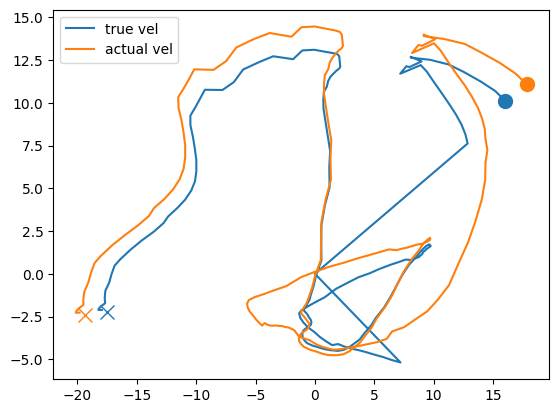

In [61]:


plotComparison(velocityData,predVels,plotFrom=300,plotTo=500,label = ' vel')

In [ ]:
cursor.xInvert
cursor.yInvert
pca_lr = dataProcessor.testDataGameEngine.pcaleftRight
pca_ud = dataProcessor.testDataGameEngine.pcaUpDown
pca_y = pca_ud.transform(np.asarray([-1.32410509, -1.74628657,  0.72892797]).reshape(1,-1))
normalised_y_Val = 1 - (pca_y - cursor.userMinYValue) / cursor.yRange
y_target = normalised_y_Val * 740
distanceY = y_target - cursorPos # need to find this
velY = distanceY * 0.06
velY
# we need an estimat eof the cursor pos to find this

NameError: name 'cursorPos' is not defined

In [ ]:
cursor.xInvert
cursor.yInvert
pca_lr = dataProcessor.testDataGameEngine.pcaleftRight
pca_ud = dataProcessor.testDataGameEngine.pcaUpDown
pca_y = pca_ud.transform(np.asarray([-1.32410509, -1.74628657,  0.72892797]).reshape(1,-1))
normalised_y_Val = 1 - (pca_y - cursor.userMinYValue) / cursor.yRange
y_target = normalised_y_Val * 740
distanceY = y_target - cursorPos # need to find this
velY = distanceY * 0.06
velY
# we need an estimat eof the cursor pos to find this

NameError: name 'cursorPos' is not defined

In [ ]:
cursor.xInvert
cursor.yInvert
pca_lr = dataProcessor.testDataGameEngine.pcaleftRight
pca_ud = dataProcessor.testDataGameEngine.pcaUpDown
pca_y = pca_ud.transform(np.asarray([-1.32410509, -1.74628657,  0.72892797]).reshape(1,-1))
normalised_y_Val = 1 - (pca_y - cursor.userMinYValue) / cursor.yRange
y_target = normalised_y_Val * 740
distanceY = y_target - cursorPos # need to find this
velY = distanceY * 0.06
velY
# we need an estimat eof the cursor pos to find this